In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


First, we define the data generation and visualization functions. Here the underlying generation process uses 2 concepts - each of which is aligned with a standart basis vector of $\mathbb{R}^2$:

In [49]:
from dataclasses import dataclass
from typing import Tuple, Dict

torch.manual_seed(42)
np.random.seed(42)

@dataclass
class ToyData:
    X: torch.Tensor               # (n, 2)
    Y: torch.Tensor               # (n, 2) binary labels
    meta: Dict[str, float]        # parameters used to generate the data

def generate_toy_2d(
    n: int = 600,
    p1: float = 0.45,                    # P(y1=1)
    p2: float = 0.40,                    # P(y2=1)
    corr_labels: torch.Tensor = None,    # (2,2) correlation for label GP (required for dependence)
    corr_features: torch.Tensor = None,  # (2,2) correlation for feature noise (optional)
    noise_scale: float = 0.2,
    strength1: float = 1.0,             # signal strength for concept 1
    strength2: float = 1.0,             # signal strength for concept 2
    offset: Tuple[float, float] = (2.0, 2.0),
    device: str = "cpu"
) -> ToyData:
    """
    Generate a 2D toy dataset where *labels are coupled* via a 2D Gaussian (probit / Gaussian copula)
    with a specified correlation matrix. Features are then created as a linear signal of the two
    concepts plus *correlated Gaussian* noise controlled by corr_features.

    Label model (Gaussian copula / probit):
        z ~ N(0, corr_labels),   y_i = 1{ z_i > Phi^{-1}(1 - p_i) },  i=1,2
      => P(y_i=1)=p_i (exact), dependence governed by corr_labels.

    Feature model:
        X = y1 * strength1 * e1 + y2 * strength2 * e2 + eps,
        eps ~ N(0, corr_features) * noise_scale

    Returns:
        ToyData(X: (n,2), Y: (n,2), meta: dict)
    """

    # --- Defaults & validation for correlation matrices ---
    if corr_labels is None:
        raise ValueError("corr_labels must be provided as a 2x2 correlation matrix for the 2D Gaussian process.")
    corr_labels = torch.as_tensor(corr_labels, dtype=torch.float32, device=device)
    if corr_labels.shape != (2, 2):
        raise ValueError(f"corr_labels must have shape (2,2), got {tuple(corr_labels.shape)}.")
    if not torch.allclose(torch.diag(corr_labels), torch.ones(2, device=device), atol=1e-6):
        raise ValueError("corr_labels must have ones on its diagonal.")
    # PSD check (allow tiny negative eigenvalues due to num. issues)
    if torch.linalg.eigvalsh(corr_labels).min() < -1e-8:
        raise ValueError("corr_labels must be positive semidefinite.")

    if corr_features is None:
        corr_features = torch.eye(2, device=device)
    else:
        corr_features = torch.as_tensor(corr_features, dtype=torch.float32, device=device)
        if corr_features.shape != (2, 2):
            raise ValueError(f"corr_features must have shape (2,2), got {tuple(corr_features.shape)}.")
        if not torch.allclose(torch.diag(corr_features), torch.ones(2, device=device), atol=1e-6):
            raise ValueError("corr_features must have ones on its diagonal.")
        if torch.linalg.eigvalsh(corr_features).min() < -1e-8:
            raise ValueError("corr_features must be positive semidefinite.")

    # --- Sample labels via a 2D Gaussian process (Gaussian copula / probit link) ---
    # thresholds to match desired marginals exactly
    std_normal = torch.distributions.Normal(loc=0.0, scale=1.0)
    t1 = std_normal.icdf(torch.tensor(1.0 - p1, device=device, dtype=torch.float32))
    t2 = std_normal.icdf(torch.tensor(1.0 - p2, device=device, dtype=torch.float32))

    L_lbl = torch.linalg.cholesky(corr_labels)
    z = torch.randn(n, 2, device=device) @ L_lbl.T
    y1 = (z[:, 0] > t1).float().unsqueeze(1)
    y2 = (z[:, 1] > t2).float().unsqueeze(1)
    Y = torch.cat([y1, y2], dim=1)  # (n,2)

    # Ensure all four label combinations appear at least once (optional but handy for demos)
    combos = {(0,0): False, (1,0): False, (0,1): False, (1,1): False}
    for i in range(n):
        tup = (int(Y[i,0].item()), int(Y[i,1].item()))
        combos[tup] = True
    idx = 0
    for tup, ok in combos.items():
        if not ok and idx < n:
            Y[idx,0] = tup[0]
            Y[idx,1] = tup[1]
            idx += 1

    # --- Build features from concepts + correlated Gaussian noise ---
    e1 = torch.tensor([1.0, 0.0], device=device)
    e2 = torch.tensor([0.0, 1.0], device=device)

    mean_part = (Y[:, [0]] * strength1) * e1 + (Y[:, [1]] * strength2) * e2  # (n,2)

    L_feat = torch.linalg.cholesky(corr_features)
    eps = (torch.randn(n, 2, device=device) @ L_feat.T) * noise_scale

    # Shift samples to first quadrant for clearer visualization; concept axes remain at origin
    X = mean_part + eps + torch.tensor(offset, device=device, dtype=torch.float32)

    meta = dict(
        n=n, p1=p1, p2=p2,
        corr_labels=corr_labels.detach().cpu().tolist(),
        corr_features=corr_features.detach().cpu().tolist(),
        noise_scale=noise_scale,
        strength1=strength1, strength2=strength2,
        offset=offset
    )
    return ToyData(X=X, Y=Y, meta=meta)


def visualize_toy_2d(
    data: ToyData,
    title: str = "2D Toy Data (two concepts)",
    cavs: torch.Tensor = None,         # optional: (2, n_features)
    scale: float = 1.0                 # optional scaling for arrow length
) -> None:
    """Scatter plot of 2D toy data grouped by concept labels, optionally visualizing given CAVs."""
    X = data.X.cpu().numpy()
    Y = data.Y.cpu().numpy()

    classes = {
        (0,0): {"mask": (Y[:,0]==0) & (Y[:,1]==0), "marker": "o", "label": "none (0,0)"},
        (1,0): {"mask": (Y[:,0]==1) & (Y[:,1]==0), "marker": "^", "label": "concept 1 (1,0)"},
        (0,1): {"mask": (Y[:,0]==0) & (Y[:,1]==1), "marker": "s", "label": "concept 2 (0,1)"},
        (1,1): {"mask": (Y[:,0]==1) & (Y[:,1]==1), "marker": "x", "label": "both (1,1)"},
    }

    plt.figure(figsize=(6.5, 6.0))
    for key, cfg in classes.items():
        plt.scatter(X[cfg["mask"], 0], X[cfg["mask"], 1],
                    marker=cfg["marker"], alpha=0.75, label=cfg["label"])

    # --- Draw the standard basis arrows e1, e2 from origin ---
    plt.quiver(0, 0, 1.0, 0.0, angles='xy', scale_units='xy', scale=1.0, width=0.005)
    plt.quiver(0, 0, 0.0, 1.0, angles='xy', scale_units='xy', scale=1.0, width=0.005)
    plt.text(1.05, 0.0, "e1", ha='left', va='bottom')
    plt.text(0.0, 1.05, "e2", ha='left', va='bottom')

    # --- Optionally draw learned CAV arrows at offset position ---
    if cavs is not None:
        cavs_np = cavs.detach().cpu().numpy()
        if cavs_np.shape[0] == 2 and cavs_np.shape[1] == 2:
            offx, offy = data.meta.get("offset", (0.0, 0.0))
            for i, vec in enumerate(cavs_np):
                plt.quiver(offx, offy, vec[0]*scale, vec[1]*scale,
                           angles='xy', scale_units='xy', scale=1.0, width=0.007,
                           color='C'+str(i+4), label=f'CAV {i+1}')
        else:
            print(f"[visualize_toy_2d] Expected cavs of shape (2, 2), got {cavs_np.shape} — skipping arrows.")

    plt.title(title)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.axis('equal')
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()

## 1. Joint CAV Optimization via Gradient-Descent vs via Closed-form Solution

We start by generating a toy dataset.

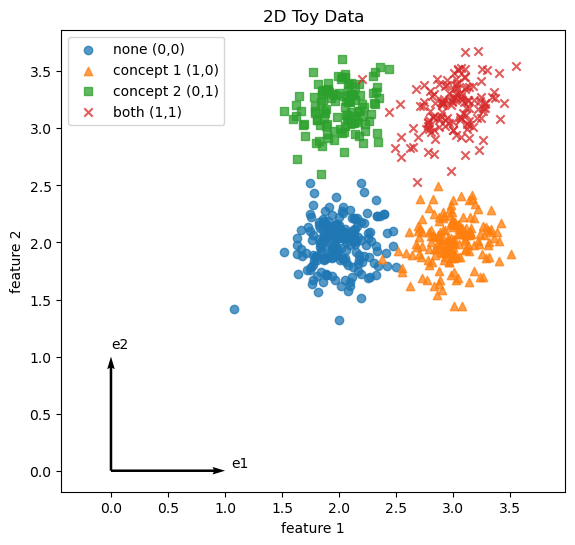

In [59]:
# Weakly correlated label Gaussian (almost independent)
corr_labels = torch.tensor([
    [1.0, 0.1],   # very low correlation between concepts
    [0.1, 1.0]
])

# Feature noise correlation (also weak)
corr_features = torch.tensor([
    [1.0, 0.2],
    [0.2, 1.0]
])

# Generate dataset
toy = generate_toy_2d(
    n=600,
    p1=0.5,                 # 50% of samples have concept 1 active
    p2=0.4,                 # 40% have concept 2 active
    corr_labels=corr_labels,   # correlation among labels
    corr_features=corr_features,  # correlation in feature noise
    noise_scale=0.2,
    strength1=1.0,
    strength2=1.2,
    offset=(2.0, 2.0)
)

visualize_toy_2d(toy, title="2D Toy Data")

Now, we can carry on the joint CAV training procedure to optimize the joint CAV loss:

In [60]:
from tqdm.notebook import tqdm
from cav_models import LinearCAV

def train_cavs(
        data: ToyData,
        cavs: LinearCAV,
        num_epochs: int = 500,
        batch_size: int = 64,
        lr: float = 0.005
) -> None:
    """Train CAVs on the toy data."""
    X, Y = data.X, data.Y
    n = X.shape[0]
    optimizer = torch.optim.Adam(cavs.parameters(), lr=lr)

    dataset = torch.utils.data.TensorDataset(X, Y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    cavs.train()
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for batch_X, batch_Y in dataloader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            loss, _ = cavs.train_step(batch_X, batch_Y, 0)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        epoch_loss /= n
        if (epoch + 1) % 20 == 0 or epoch == 0:
            tqdm.write(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

cav_model = LinearCAV(n_concepts=2, n_features=2, device=device)
train_cavs(toy, cav_model)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500, Loss: 8.0391
Epoch 20/500, Loss: 2.9725
Epoch 40/500, Loss: 1.5795
Epoch 60/500, Loss: 0.9348
Epoch 80/500, Loss: 0.5266
Epoch 100/500, Loss: 0.2820
Epoch 120/500, Loss: 0.1492
Epoch 140/500, Loss: 0.0847
Epoch 160/500, Loss: 0.0567
Epoch 180/500, Loss: 0.0460
Epoch 200/500, Loss: 0.0424
Epoch 220/500, Loss: 0.0413
Epoch 240/500, Loss: 0.0411
Epoch 260/500, Loss: 0.0410
Epoch 280/500, Loss: 0.0410
Epoch 300/500, Loss: 0.0410
Epoch 320/500, Loss: 0.0410
Epoch 340/500, Loss: 0.0410
Epoch 360/500, Loss: 0.0410
Epoch 380/500, Loss: 0.0410
Epoch 400/500, Loss: 0.0410
Epoch 420/500, Loss: 0.0410
Epoch 440/500, Loss: 0.0410
Epoch 460/500, Loss: 0.0410
Epoch 480/500, Loss: 0.0410
Epoch 500/500, Loss: 0.0410


And compare the result with closed form solution:

CAVs via Gradient Descent: tensor([[0.9999, 0.0133],
        [0.0067, 1.0000]])
CAVs via Closed Form Solution: tensor([[0.9999, 0.0139],
        [0.0069, 1.0000]])
Bias: tensor([[1.9979, 1.9949]])
Offset: [2.0, 2.0]


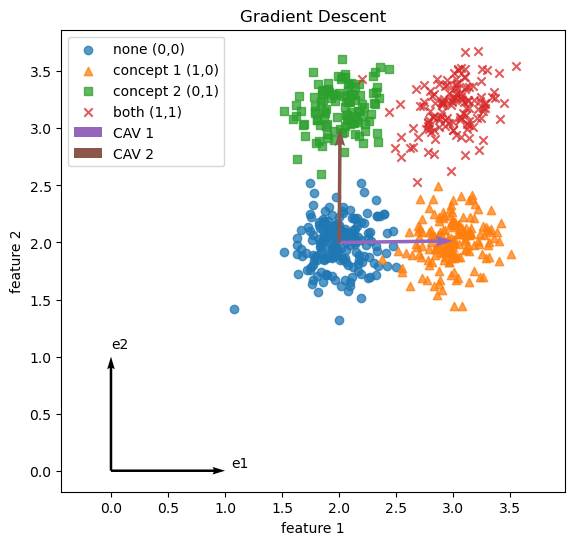

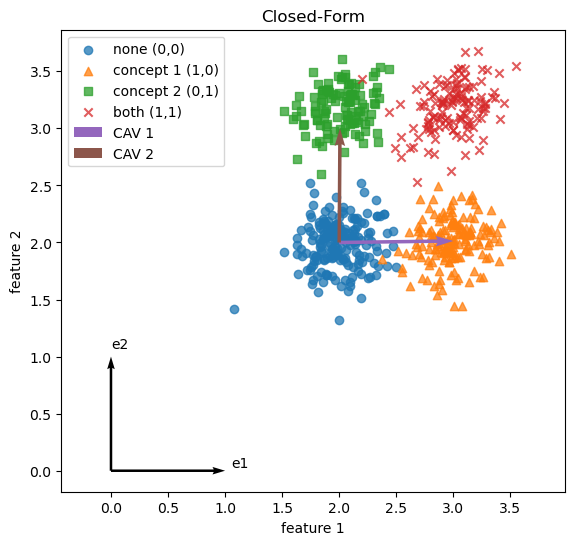

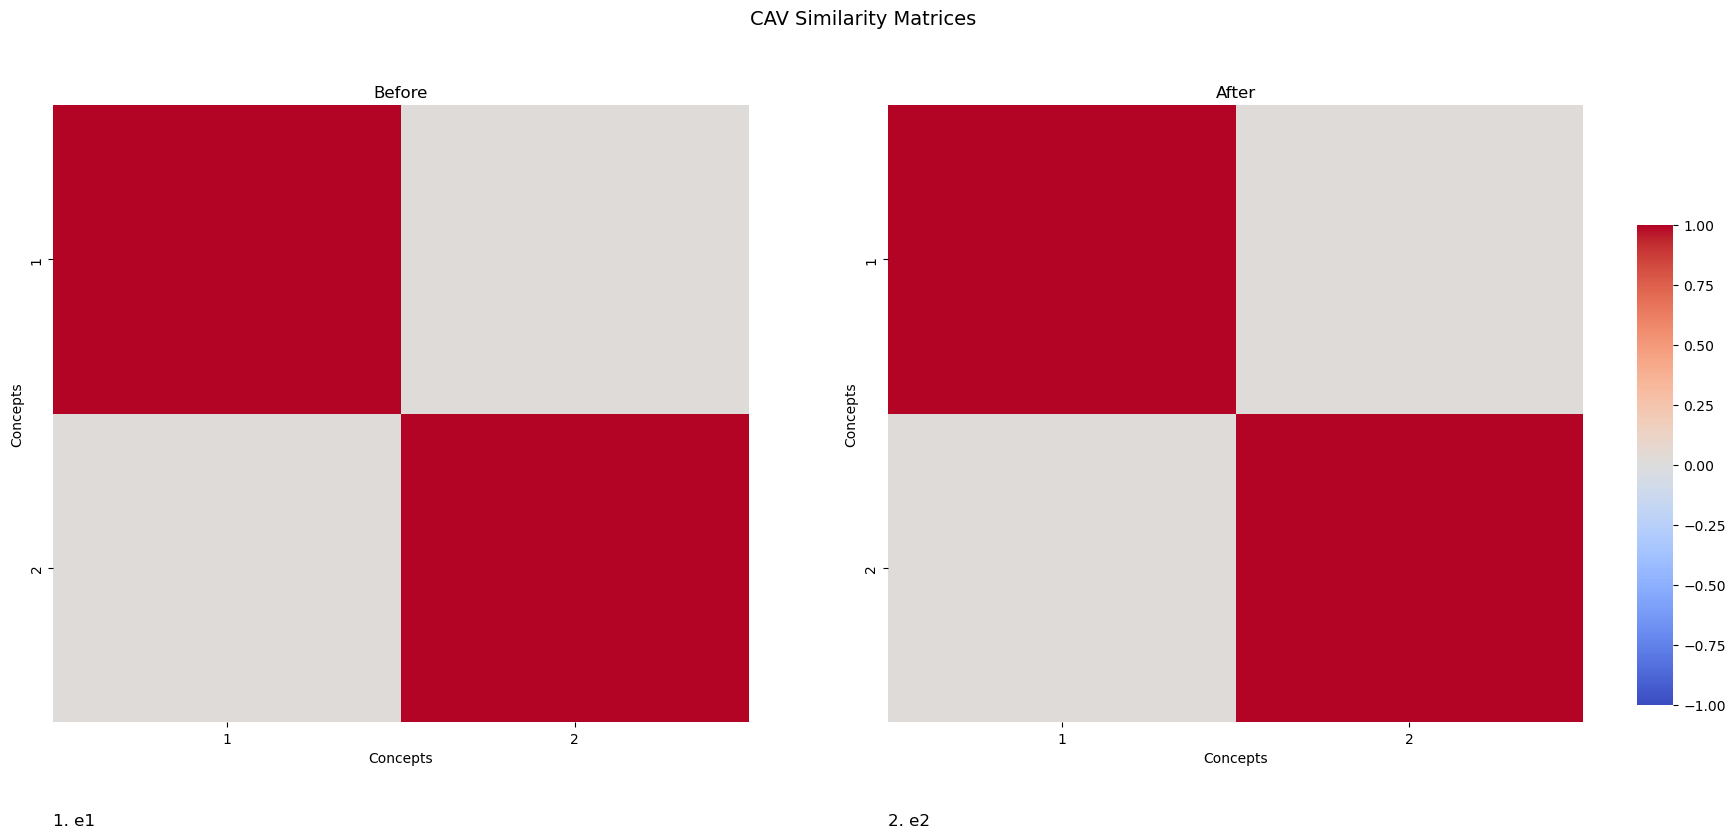

In [62]:
from utils.cav import compute_cavs
from utils.visualizations import visualize_before_after_sim_matrices

cavs, b = cav_model.get_params()
cavs = cavs / torch.norm(cavs, dim=1, keepdim=True)  # normalize to unit length
cavs_original, b_original = compute_cavs(toy.X, toy.Y, type="linear_cav")

print(f"CAVs via Gradient Descent: {cavs}")
print(f"CAVs via Closed Form Solution: {cavs_original}")

print(f"Bias: {b}")
print(f"Offset: {[2.0,2.0]}")

C_original = (cavs_original @ cavs_original.T).cpu()
C = (cavs @ cavs.T).detach().cpu()

visualize_toy_2d(toy, title="Gradient Descent", cavs=cavs_original, scale=1)
visualize_toy_2d(toy, title="Closed-Form", cavs=cavs, scale=1)
visualize_before_after_sim_matrices(C_original, C, labels=['e1', 'e2'], title="CAV Similarity Matrices")

As can be seen they coincide.

## 2. Joint-CAV vs Pattern-CAV

Again, we start by generating a toy set, and fitting both Pattern and Joint CAVs into it.

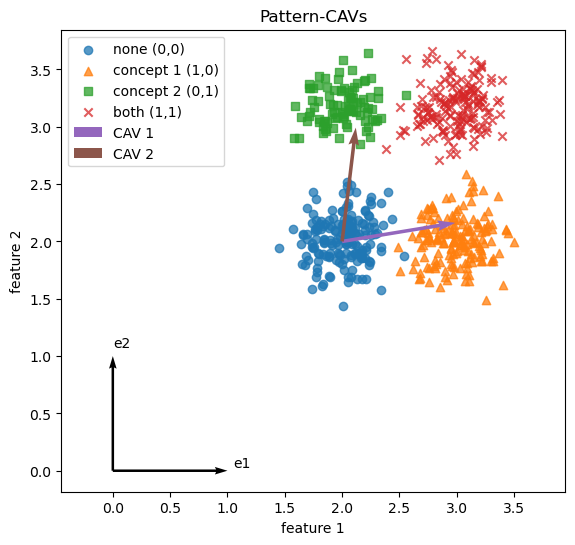

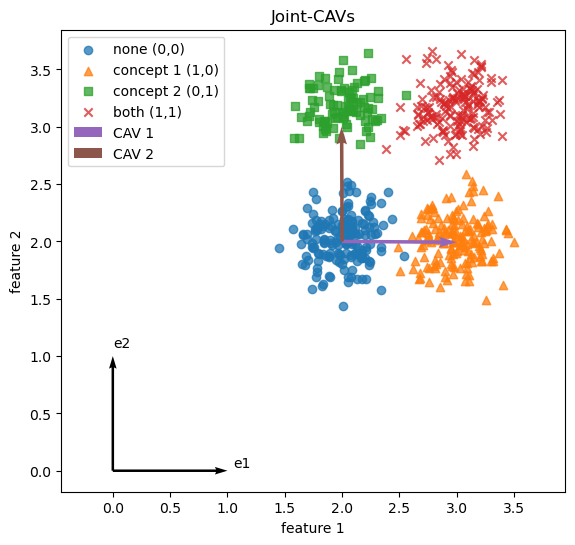

In [ ]:
from utils.cav import compute_cavs

corr_labels = torch.tensor([
    [1.0, 0.1],   # weak positive correlation between concepts
    [0.1, 1.0]
])

# Feature noise correlation matrix
corr_features = torch.tensor([
    [1.0, 0.1],    # weak correlation between feature noise dimensions
    [0.1, 1.0]
])

# Generate dataset
toy = generate_toy_2d(
    n=600,
    p1=0.5,                 # 50% of samples have concept 1 active
    p2=0.4,                 # 40% have concept 2 active
    corr_labels=corr_labels,   # correlation among labels
    corr_features=corr_features,  # correlation in feature noise
    noise_scale=0.2,
    strength1=1.0,
    strength2=1.2,
    offset=(2.0, 2.0)
)

cavs_pattern, b_pattern = compute_cavs(toy.X, toy.Y, type="pattern_cav")
cavs_joint, b_joint = compute_cavs(toy.X, toy.Y, type="multi_cav")

visualize_toy_2d(toy, title="Pattern CAVs", cavs=cavs_pattern, scale=1)
visualize_toy_2d(toy, title="Multi-Pattern CAVs", cavs=cavs_joint, scale=1)

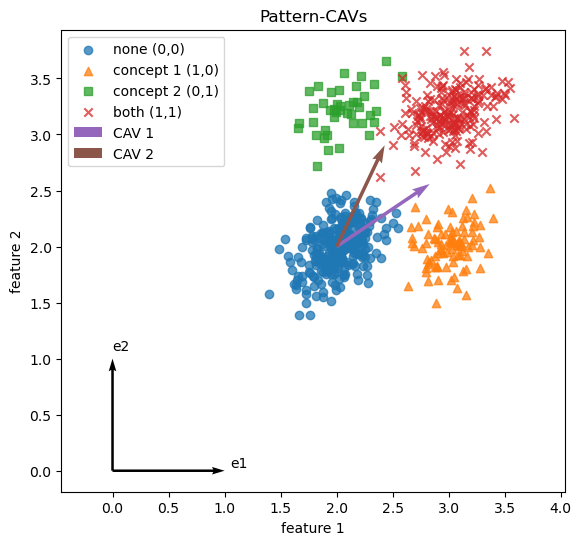

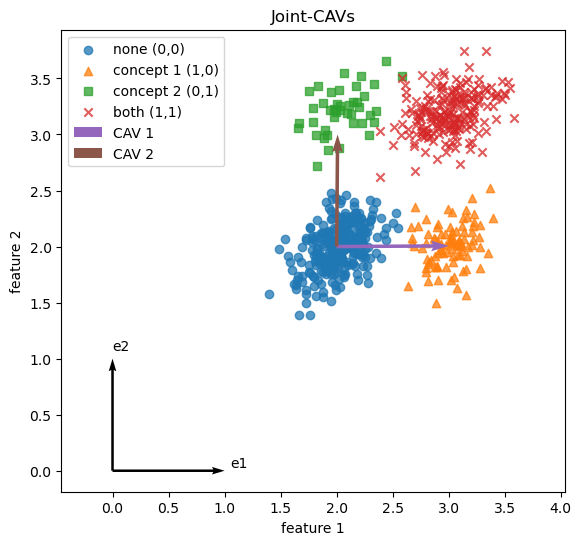

In [ ]:
corr_labels = torch.tensor([
    [1.0, 0.75],   # strong positive correlation between concepts
    [0.75, 1.0]
])

# Feature noise correlation matrix
corr_features = torch.tensor([
    [1.0, 0.4],    # moderate correlation between feature noise dimensions
    [0.4, 1.0]
])

# Generate dataset
toy = generate_toy_2d(
    n=600,
    p1=0.5,                 # 50% of samples have concept 1 active
    p2=0.4,                 # 40% have concept 2 active
    corr_labels=corr_labels,   # correlation among labels
    corr_features=corr_features,  # correlation in feature noise
    noise_scale=0.2,
    strength1=1.0,
    strength2=1.2,
    offset=(2.0, 2.0)
)

cavs_pattern, b_pattern = compute_cavs(toy.X, toy.Y, type="pattern_cav")
cavs_joint, b_joint = compute_cavs(toy.X, toy.Y, type="multi_cav")

visualize_toy_2d(toy, title="Pattern CAVs", cavs=cavs_pattern, scale=1)
visualize_toy_2d(toy, title="Multi-Pattern CAVs", cavs=cavs_joint, scale=1)

Now we compute both CAVs to compare: